In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import SeogiUtils as Sutils
from SimPEG import Mesh, Utils
import numpy as np

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16, 'text.usetex': True})

In [4]:
ncx, ncy, ncz, cs = 200, 1, 100, 5
hx = np.ones(ncx)*cs
hy = np.ones(ncy)*cs
hz = np.ones(ncz)*cs
mesh = Mesh.TensorMesh([hx, hy, hz], 'CCN')

In [5]:
def R1fFun(sig1, sig2):
    return (sig2-sig1)/(sig2+2*sig1)
def R2fFun(sig1, sig2):
    return 3*sig1/(sig2+2*sig1)

In [6]:
ind, G = Sutils.BiotSavart.SphereGeometric(mesh.gridCC, 100,  0., 0., -250.)

In [7]:
def ETDCfun(sig1, sig2, ind, G):
    E = np.zeros_like(G)
    #inside
    rf1 = R1fFun(sig1, sig2)
    rf2 = R2fFun(sig1, sig2)
    E[ind,0] = rf2
    #outside
    E[~ind,:] = rf1*G[~ind,:]
    E[~ind,0] +=  1.
    return E

In [8]:
def JTDCfun(sig1, sig2, ind, G):
    J = np.zeros_like(G)
    #inside
    rf1 = R1fFun(sig1, sig2)
    rf2 = R2fFun(sig1, sig2)
    J[ind,0] = rf2*sig2
    #outside
    J[~ind,:] = sig1*(rf1*G[~ind,:])
    J[~ind,0] +=  sig1
    return J

In [9]:
def minandmax(vec1, vec2):
    val = np.r_[np.sqrt((vec1**2).sum(axis=1)), np.sqrt((vec2**2).sum(axis=1))]
    vmin = val.min()
    vmax = val.max()
    return vmin, vmax

## Step1: Visualize electric field and current density (DC)

In [10]:
sigout, sigin1, sigin2 = 1e0, 1e2, 1e-2

E3 = np.c_[np.ones(mesh.nC), np.zeros(mesh.nC), np.zeros(mesh.nC)]
J3 = np.c_[sigout*np.ones(mesh.nC), np.zeros(mesh.nC), np.zeros(mesh.nC)]

E1 = ETDCfun(sigout, sigin1, ind, G)
J1 = JTDCfun(sigout, sigin1, ind, G)-J3
E2 = ETDCfun(sigout, sigin2, ind, G)
J2 = JTDCfun(sigout, sigin2, ind, G)-J3

vEmin, vEmax = minandmax(E1, E2)
vJmin, vJmax = minandmax(J1, J2)

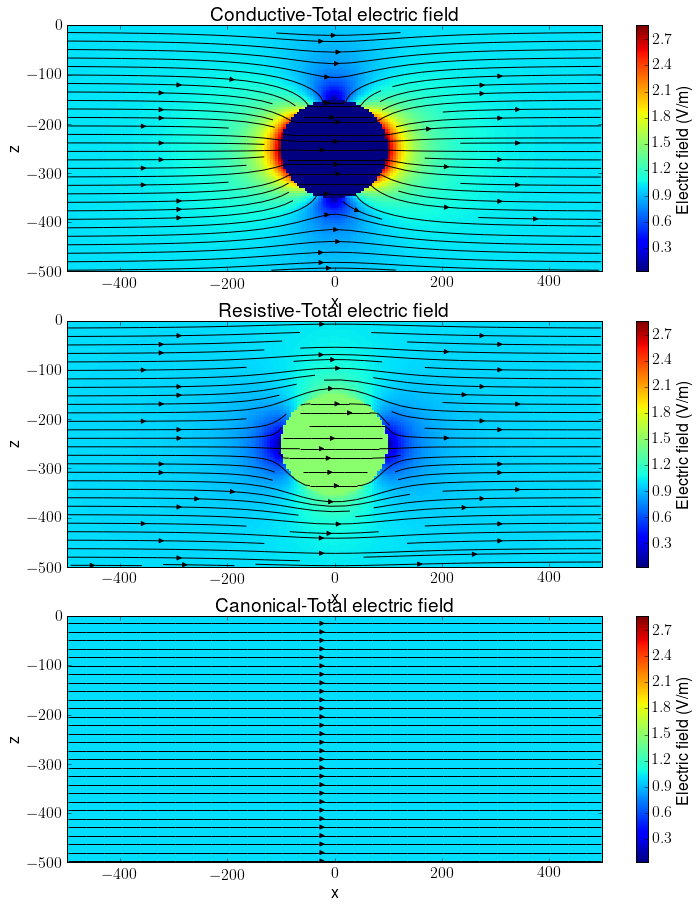

In [11]:
fig = plt.figure(figsize = (12, 15))
ax1 = plt.subplot(311)
dat = mesh.plotSlice(E1, normal='Y', view='vec', clim = (vEmin, vEmax), vType = 'CCv', streamOpts={'color':'k'}, ax = ax1)
cb = plt.colorbar(dat[0], ax = ax1); ax1.set_title("Conductive-Total electric field")
cb.set_label("Electric field (V/m)")
ax1 = plt.subplot(312)
dat = mesh.plotSlice(E2, normal='Y', view='vec', clim = (vEmin, vEmax), vType = 'CCv', streamOpts={'color':'k'}, ax = ax1)
cb = plt.colorbar(dat[0], ax = ax1); ax1.set_title("Resistive-Total electric field")
cb.set_label("Electric field (V/m)")
ax1 = plt.subplot(313)
dat = mesh.plotSlice(E3, normal='Y', view='vec', clim = (vEmin, vEmax), vType = 'CCv', streamOpts={'color':'k'}, ax = ax1)
cb = plt.colorbar(dat[0], ax = ax1); ax1.set_title("Canonical-Total electric field")
cb.set_label("Electric field (V/m)")

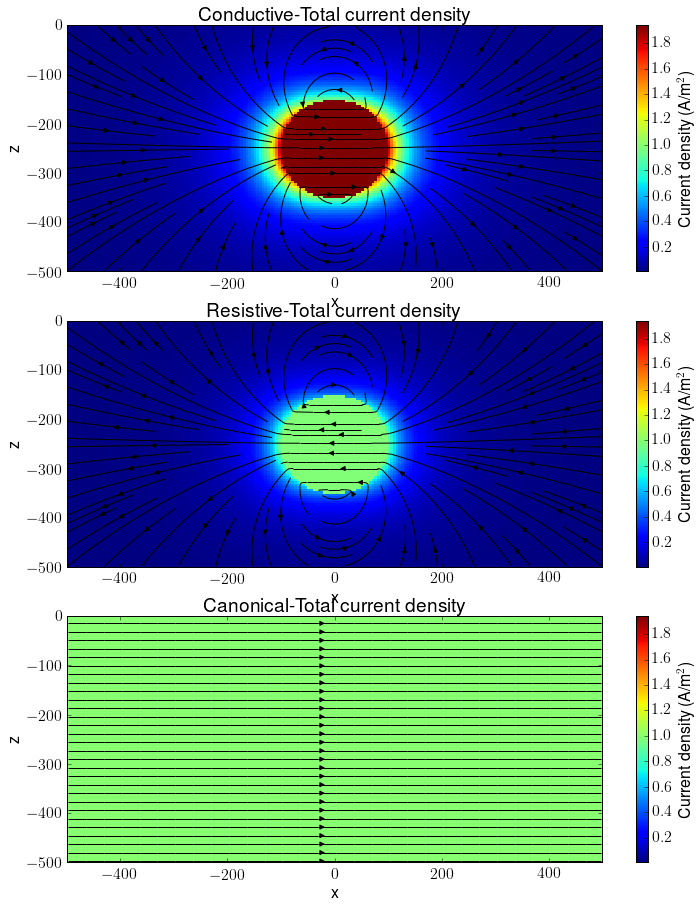

In [12]:
fig = plt.figure(figsize = (12, 15))
ax1 = plt.subplot(311)
dat = mesh.plotSlice(J1, normal='Y', view='vec', clim = (vJmin, vJmax), vType = 'CCv', streamOpts={'color':'k'}, ax = ax1)
cb = plt.colorbar(dat[0], ax = ax1); ax1.set_title("Conductive-Total current density")
cb.set_label("Current density (A/m$^2$)")
ax1 = plt.subplot(312)
dat = mesh.plotSlice(J2, normal='Y', view='vec', clim = (vJmin, vJmax), vType = 'CCv', streamOpts={'color':'k'}, ax = ax1)
cb = plt.colorbar(dat[0], ax = ax1); ax1.set_title("Resistive-Total current density")
cb.set_label("Current density (A/m$^2$)")
ax1 = plt.subplot(313)
dat = mesh.plotSlice(J3, normal='Y', view='vec', clim = (vJmin, vJmax), vType = 'CCv', streamOpts={'color':'k'}, ax = ax1)
cb = plt.colorbar(dat[0], ax = ax1); ax1.set_title("Canonical-Total current density")
cb.set_label("Current density (A/m$^2$)")

## Step2: Visualize electric field (DC-IP)

In [58]:
def R1fIPFunOff(sig1, sig2, eta, tau, time):
    r1 = np.zeros_like(time)
    r2 = np.zeros_like(time)
    R1bar = (sig2*(1-eta)-sig1) / (sig2*(1-eta)+2*sig1)
    R2 = (3*sig1) / (sig2+2*sig1)    
    R2bar = (3*sig1) / (sig2*(1-eta)+2*sig1)    
    R1barsig = (sig2*eta) / (sig2*(1-eta)+2*sig1)
    b = 1./ ((1-eta)*tau)
    B = (sig2*(1-eta)+2*sig1) / (sig2+2*sig1) * b
    if time > 0.:
        r1 = -R1barsig*R2*np.exp(-B*time)    
    else:
        r1 = R1bar
    return r1

In [59]:
def RfIPFunOff(sig1, sig2, eta, tau, time):
    r1 = np.zeros_like(time)
    r2 = np.zeros_like(time)
    R1bar = (sig2*(1-eta)-sig1) / (sig2*(1-eta)+2*sig1)
    R2 = (3*sig1) / (sig2+2*sig1)    
    R1barsig = (sig2*eta) / (sig2*(1-eta)+2*sig1)
    R2bar = (3*sig1) / (sig2*(1-eta)+2*sig1)        
    print R2, R1barsig
    b = 1./ ((1-eta)*tau)
    B = (sig2*(1-eta)+2*sig1) / (sig2+2*sig1) * b
    r1[time<=0.] = R1bar
    r1[time>0.] = -R1barsig*R2*np.exp(-B*time[time >0.])
    r2[time<=0.] = R2bar
    r2[time>0.] = -R1barsig*R2*np.exp(-B*time[time >0.])    
    return r1, r2

In [60]:
time = np.logspace(-3, 0, 101)

In [61]:
def foo(x, eta):
    return 3*x/(1+2*x)*eta/((1-eta)+2*x)

In [62]:
# x = np.logspace(-5, 5, 2**8)
# f = foo(x, 0.1)
# plt.loglog(x, f)
# print f.max()

In [63]:
print 0.1/(3-0.1)

0.0344827586207


In [64]:
r1off1, r2off1 = RfIPFunOff(sigout, sigin1, 0.1, 0.1, time)
r1off2, r2off2 = RfIPFunOff(sigout, sigin2, 0.1, 0.1, time)
r1off3, r2off3 = RfIPFunOff(sigout, sigout, 0.1, 0.1, time)

0.0294117647059 0.108695652174
1.49253731343 0.000497760079642
1.0 0.0344827586207


In [65]:
def EIPfun(sig1, sig2, eta, tau, ind, G, t):
    E = np.zeros_like(G)
    #inside
    rf1 = R1fIPFunOff(sig1, sig2, eta, tau, t)
    rf2 = rf1.copy()
    E[ind,0] = -rf2
    #outside
    E[~ind,:] = rf1*G[~ind,:]
#     E[~ind,0] +=  1.
    return E

In [66]:
E1 = ETDCfun(sigout, sigin1, ind, G)
EIP1 = EIPfun(sigout, sigin1, 0.1, 0.1, ind, G, 0.01)
E2 = ETDCfun(sigout, sigin2, ind, G)
EIP2 = EIPfun(sigout, sigin2, 0.1, 0.1, ind, G, 0.01)
E3 = np.c_[np.ones(mesh.nC), np.zeros(mesh.nC), np.zeros(mesh.nC)]
EIP3 = EIPfun(sigout, sigout, 0.1, 0.1, ind, G, 0.01)
vEmin, vEmax = minandmax(E1, E2)
vEIPmin, vEIPmax = minandmax(EIP1, EIP3)

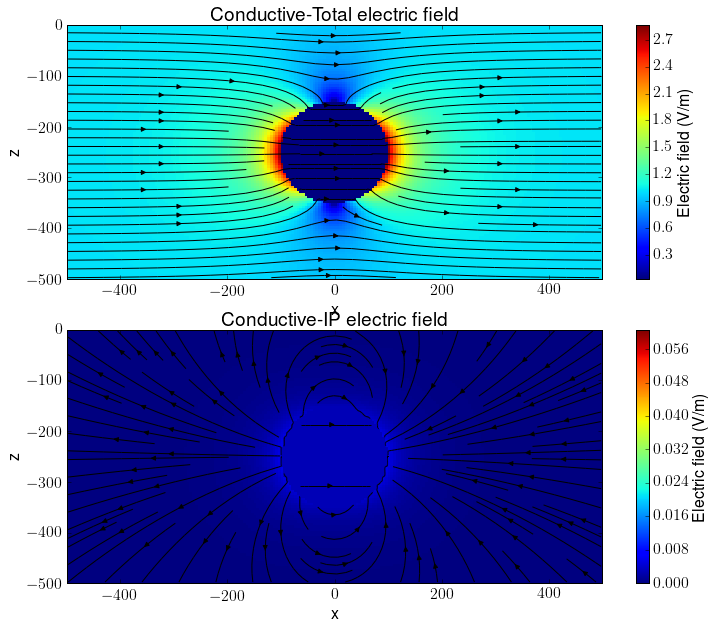

In [67]:
fig = plt.figure(figsize = (12, 10))
ax1 = plt.subplot(211)
dat = mesh.plotSlice(E1, normal='Y', clim = (vEmin, vEmax), view='vec', vType = 'CCv', streamOpts={'color':'k'}, ax = ax1)
cb = plt.colorbar(dat[0], ax = ax1); ax1.set_title("Conductive-Total electric field")
cb.set_label("Electric field (V/m)")
ax1 = plt.subplot(212)
dat = mesh.plotSlice(EIP1, normal='Y', clim = (vEIPmin, vEIPmax), view='vec', vType = 'CCv', streamOpts={'color':'k'}, ax = ax1)
cb = plt.colorbar(dat[0], ax = ax1); ax1.set_title("Conductive-IP electric field")
cb.set_label("Electric field (V/m)")

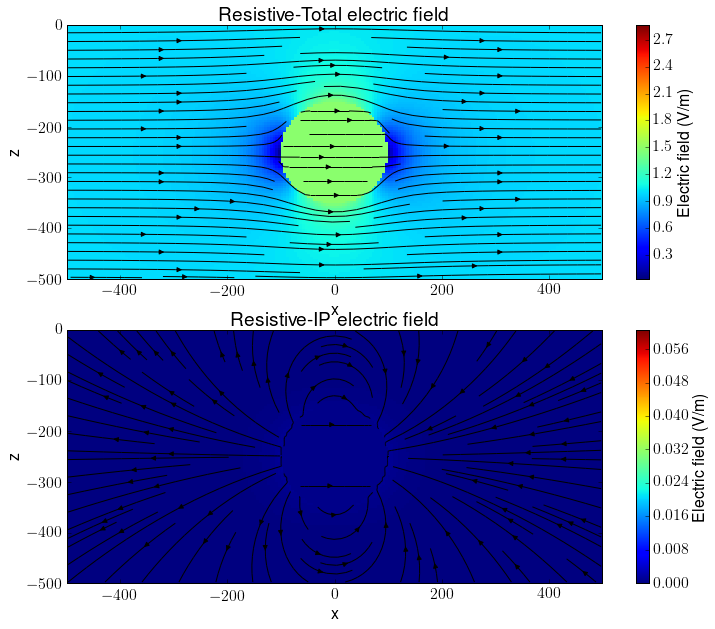

In [68]:
fig = plt.figure(figsize = (12, 10))
ax1 = plt.subplot(211)
dat = mesh.plotSlice(E2, normal='Y', clim = (vEmin, vEmax), view='vec', vType = 'CCv', streamOpts={'color':'k'}, ax = ax1)
cb = plt.colorbar(dat[0], ax = ax1); ax1.set_title("Resistive-Total electric field")
cb.set_label("Electric field (V/m)")
ax1 = plt.subplot(212)
dat = mesh.plotSlice(EIP2, normal='Y', clim = (vEIPmin, vEIPmax), view='vec', vType = 'CCv', streamOpts={'color':'k'}, ax = ax1)
cb = plt.colorbar(dat[0], ax = ax1); ax1.set_title("Resistive-IP electric field")
cb.set_label("Electric field (V/m)")

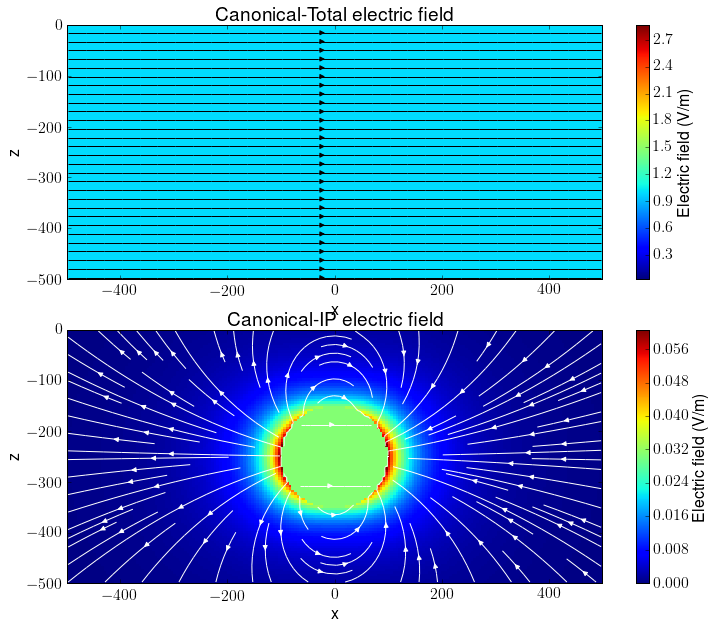

In [69]:
fig = plt.figure(figsize = (12, 10))
ax1 = plt.subplot(211)
dat = mesh.plotSlice(E3, normal='Y', clim = (vEmin, vEmax), view='vec', vType = 'CCv', streamOpts={'color':'k'}, ax = ax1)
cb = plt.colorbar(dat[0], ax = ax1); ax1.set_title("Canonical-Total electric field")
cb.set_label("Electric field (V/m)")
ax1 = plt.subplot(212)
dat = mesh.plotSlice(EIP3, normal='Y', clim = (vEIPmin, vEIPmax), view='vec', vType = 'CCv', streamOpts={'color':'w'}, ax = ax1)
cb = plt.colorbar(dat[0], ax = ax1); ax1.set_title("Canonical-IP electric field")
cb.set_label("Electric field (V/m)")

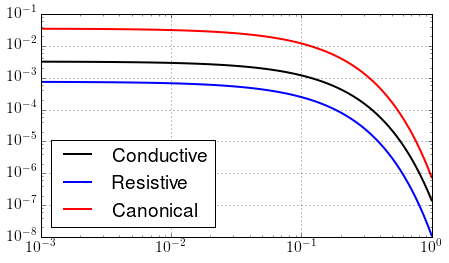

In [43]:
fig = plt.figure(figsize = (7, 4))
plt.loglog(time, -r1off1, 'k', lw = 2)
plt.loglog(time, -r1off2, 'b', lw = 2)
plt.loglog(time, -r1off3, 'r', lw = 2)
legend(("Conductive", "Resistive", "Canonical"), loc=3)
plt.grid(True)

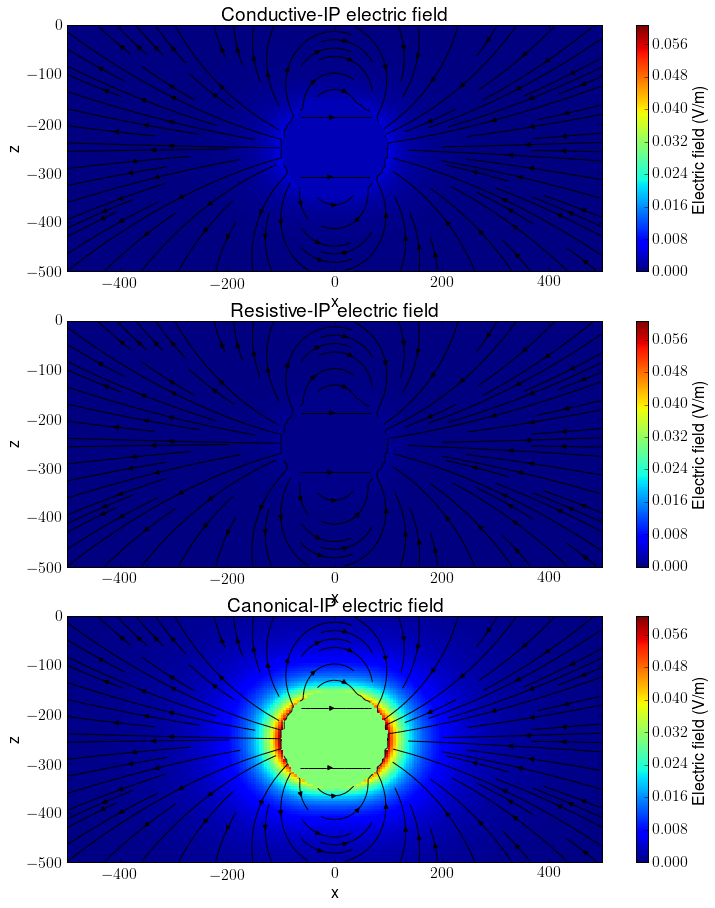

In [73]:
fig = plt.figure(figsize = (12, 15))
ax1 = plt.subplot(311)
dat = mesh.plotSlice(EIP1, normal='Y', clim = (vEIPmin, vEIPmax), view='vec', vType = 'CCv', streamOpts={'color':'k'}, ax = ax1)
cb = plt.colorbar(dat[0], ax = ax1); ax1.set_title("Conductive-IP electric field")
cb.set_label("Electric field (V/m)")
ax2 = plt.subplot(312)
dat = mesh.plotSlice(EIP2, normal='Y', clim = (vEIPmin, vEIPmax), view='vec', vType = 'CCv', streamOpts={'color':'k'}, ax = ax2)
cb = plt.colorbar(dat[0], ax = ax2); ax2.set_title("Resistive-IP electric field")
cb.set_label("Electric field (V/m)")
ax3 = plt.subplot(313)
dat = mesh.plotSlice(EIP3, normal='Y', clim = (vEIPmin, vEIPmax), view='vec', vType = 'CCv', streamOpts={'color':'k'}, ax = ax3)
cb = plt.colorbar(dat[0], ax = ax3); ax3.set_title("Canonical-IP electric field")
cb.set_label("Electric field (V/m)")

In [74]:
def JIP123OFF_scalar(sig1, sig2, eta, tau, time):
    R2 = (3.*sig1) / (sig2+2*sig1)    
    R2bar = (3*sig1) / (sig2*(1-eta)+2*sig1)            
    R1barsig = (sig2*eta) / (sig2*(1.-eta)+2.*sig1)
    A = R2*R1barsig
    b = 1./ ((1-eta)*tau)
    a = eta*b
    B = (sig2*(1.-eta)+2.*sig1) / (sig2+2.*sig1) * b
    if time < 0.:
#         j1in = sig2*R1barsig
#         j1out = sig1*R1barsig
        j2 = 0.
        j3 = 0.
    else:
        j1out = -sig1*A*np.exp(-B*time)        
        j1 =  sig2*A*np.exp(-B*time)
        j2 = -sig2*R2bar*eta*exp(-b*time) + sig2*R2*eta*exp(-b*time)
        j3 = -sig2*A*a/(b-B)*(np.exp(-B*time)-np.exp(-b*time))-sig2*R2*eta*exp(-b*time)

    return j1out, j1, j2, j3

In [75]:
def JIP123OFF(sig1, sig2, eta, tau, time):
    j1 = np.zeros_like(time)
    j2 = np.zeros_like(time)
    j3 = np.zeros_like(time)    
    R2 = (3.*sig1) / (sig2+2*sig1)    
    R2bar = (3*sig1) / (sig2*(1-eta)+2*sig1)            
    R1barsig = (sig2*eta) / (sig2*(1.-eta)+2.*sig1)
    A = R2*R1barsig
    b = 1./ ((1-eta)*tau)
    a = eta*b
    B = (sig2*(1.-eta)+2.*sig1) / (sig2+2.*sig1) * b
    j1 =  sig2*A*np.exp(-B*time)
    j2 = -sig2*R2bar*eta*exp(-b*time) + sig2*A*eta*exp(-b*time)
    j3 = -sig2*A*a/(b-B)*(np.exp(-B*time)-np.exp(-b*time)) - sig2*A*eta*exp(-b*time)
    
    return j1, j2, j3

In [76]:
def JIPfun(sig1, sig2, eta, tau, ind, G, t):
    J = np.zeros_like(G)
    #inside
    j1out, j1in, j2, j3 = JIP123OFF_scalar(sig1, sig2, eta, tau, t)
    J[ind,0] = j1in+j2+j3
    #outside
    print j1in, j1out
    J[~ind,:] = (j1out)*G[~ind,:]
    return J

In [77]:
sigout = 1e-2
sigin1, sigin2 = sigout*10**(2), sigout*10**(-2)
print sigout, sigin1, sigin2

0.01 1.0 0.0001


In [78]:
ja1, jb1, jc1 = JIP123OFF(sigout, sigin1, 0.4, 0.2, time)
ja2, jb2, jc2 = JIP123OFF(sigout, sigin2, 0.4, 0.2, time)
ja3, jb3, jc3 = JIP123OFF(sigout, sigout, 0.4, 0.2, time)
vmin = abs(np.r_[ja1, jb1, jc1, ja2, jb2, jc2, ja3, jb3, jc3]).min()*0.8
vmax = abs(np.r_[ja1, jb1, jc1, ja2, jb2, jc2, ja3, jb3, jc3]).max()*1.2

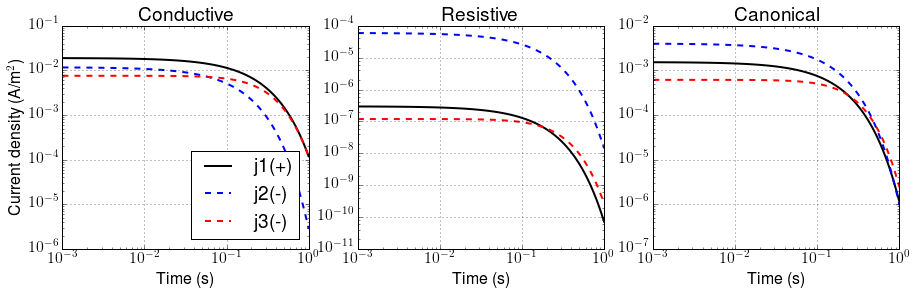

In [79]:
fig = plt.figure(figsize = (15, 4))
ax1 = plt.subplot(131)
ax1.loglog(time, ja1, 'k', lw=2)
ax1.loglog(time, -jb1, 'b--', lw=2)
ax1.loglog(time, -jc1, 'r--', lw=2)
ax1.legend(("j1(+)", "j2(-)", "j3(-)"), loc=4); 
ax1.set_title("Conductive")
ax2 = plt.subplot(132)
ax2.loglog(time, ja2, 'k', lw=2)
ax2.loglog(time, -jb2, 'b--', lw=2)
ax2.loglog(time, -jc2, 'r--', lw=2)
# ax2.legend(("j1(+)", "j2(-)", "j3(-)"), loc=4); 
ax2.set_title("Resistive")
ax3 = plt.subplot(133)
ax3.loglog(time, ja3, 'k', lw=2)
ax3.loglog(time, -jb3, 'b--', lw=2)
ax3.loglog(time, -jc3, 'r--', lw=2)
# ax3.legend(("j1(+)", "j2(-)", "j3(-)"), loc=4); 
ax3.set_title("Canonical")
ax = [ax1, ax2, ax3]
for i, iax in enumerate(ax):
    iax.grid(True)
    iax.set_xlabel("Time (s)")
    if i==0:
        iax.set_ylabel("Current density (A/m$^2$)")   
fig.savefig("../IPsphere/IPFigures/jipcurves.png", dpi=100)

In [80]:
JIP1 = JIPfun(sigout, sigin1, 0.1, 0.1, ind, G, 0.01)
JIP2 = JIPfun(sigout, sigin2, 0.1, 0.1, ind, G, 0.01)
JIP3 = JIPfun(sigout, sigout, 0.1, 0.1, ind, G, 0.01)
vJIPmin, vJIPmax = minandmax(JIP2, JIP3)

0.00289207259327 -2.89207259327e-05
6.6483569025e-08 -6.6483569025e-06
0.000309710235012 -0.000309710235012


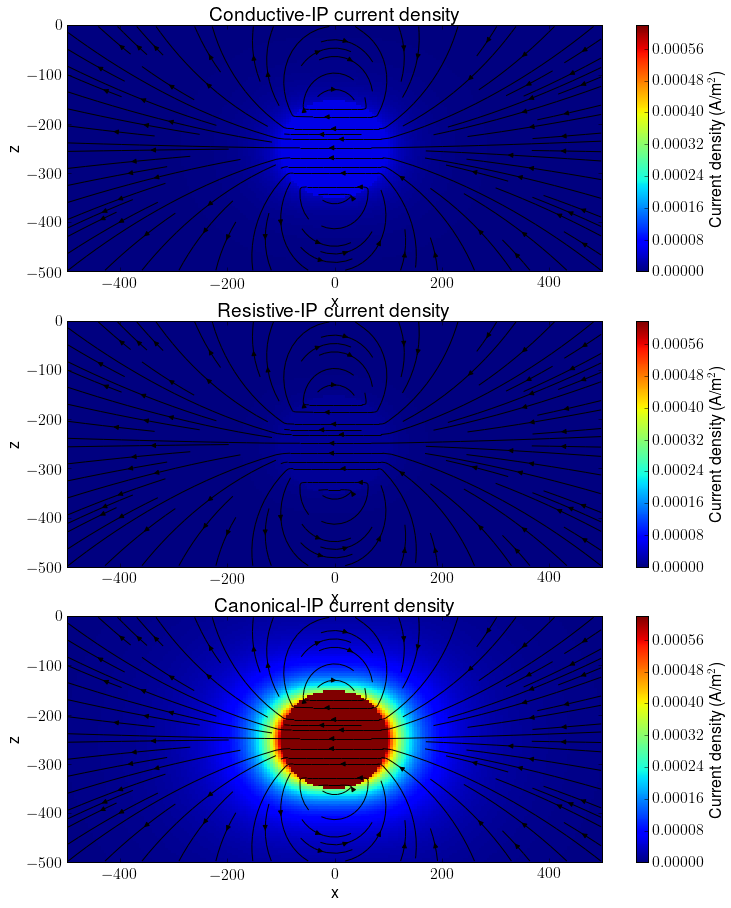

In [81]:
fig = plt.figure(figsize = (12, 15))
ax1 = plt.subplot(311)
dat = mesh.plotSlice(JIP1, normal='Y', clim = (vJIPmin, vJIPmax), view='vec', vType = 'CCv', streamOpts={'color':'k'}, ax = ax1)
cb = plt.colorbar(dat[0], ax = ax1); ax1.set_title("Conductive-IP current density")
cb.set_label("Current density (A/m$^2$)")
ax2 = plt.subplot(312)
dat = mesh.plotSlice(JIP2, normal='Y', clim = (vJIPmin, vJIPmax), view='vec', vType = 'CCv', streamOpts={'color':'k'}, ax = ax2)
cb = plt.colorbar(dat[0], ax = ax2); ax2.set_title("Resistive-IP current density")
cb.set_label("Current density (A/m$^2$)")
ax3 = plt.subplot(313)
dat = mesh.plotSlice(JIP3, normal='Y', clim = (vJIPmin, vJIPmax), view='vec', vType = 'CCv', streamOpts={'color':'k'}, ax = ax3)
cb = plt.colorbar(dat[0], ax = ax3); ax3.set_title("Canonical-IP current density")
cb.set_label("Current density (A/m$^2$)")

In [82]:
!pwd

/Users/sgkang/Projects/IPresearch/notes/notebook


In [83]:
!ls ../IPsphere/IPFigures/

ConceptModel.png    DCIPEJFund.png      PostJ.png           coleTD.png
DCEJFund.png        IPsphereVeri.png    PostJstepon.png     jipcurves.png
DCEJIP.png          Integrationpath.png PreJ.png


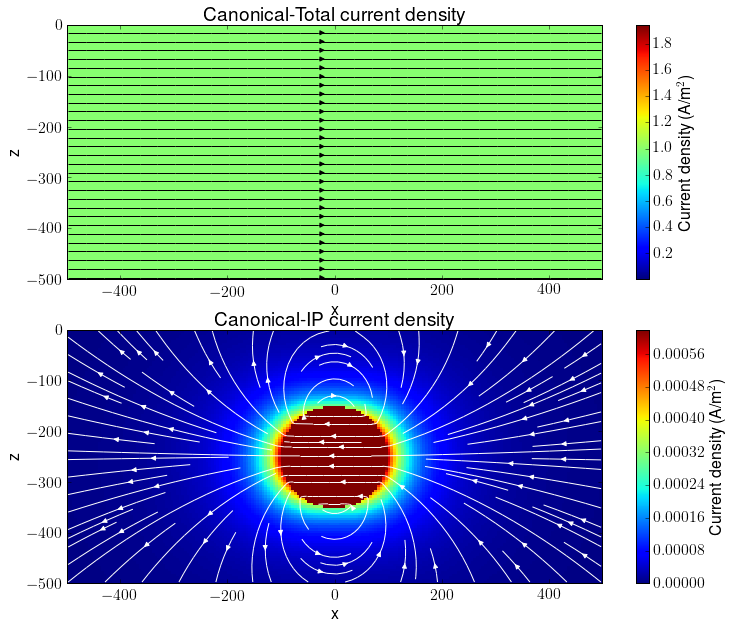

In [84]:
fig = plt.figure(figsize = (12, 10))
ax1 = plt.subplot(211)
dat = mesh.plotSlice(J3, normal='Y', clim = (vJmin, vJmax), view='vec', vType = 'CCv', streamOpts={'color':'k'}, ax = ax1)
cb = plt.colorbar(dat[0], ax = ax1); ax1.set_title("Canonical-Total current density")
cb.set_label("Current density (A/m$^2$)")
ax1 = plt.subplot(212)
dat = mesh.plotSlice(JIP3, normal='Y', clim = (vJIPmin, vJIPmax), view='vec', vType = 'CCv', streamOpts={'color':'w'}, ax = ax1)
cb = plt.colorbar(dat[0], ax = ax1); ax1.set_title("Canonical-IP current density")
cb.set_label("Current density (A/m$^2$)")
